# Melbourne Temperatures' Forecast

In [ ]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

In [ ]:
TEMPERATURES_CSV = './data/daily-min-temperatures.csv'

with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")
    print(f"First data point looks like this:\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n{csvfile.readline()}")

Header looks like this:

"Date","Temp"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
def parse_data_from_file(filename):

    times = []
    temperatures = []

    with open(filename) as csvfile:

        counter=0
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            times.append(counter)
            temperatures.append(float(row[1]))
            counter+=1
    return times, temperatures

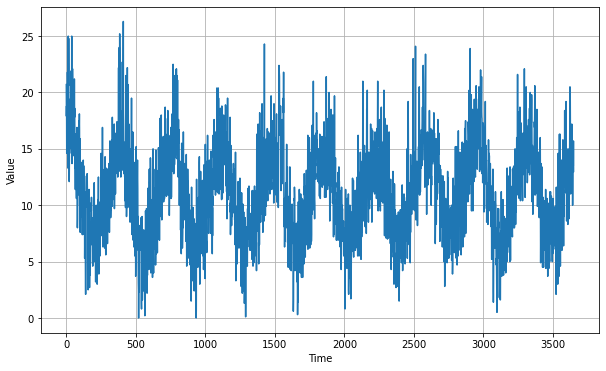

In [ ]:
@dataclass
class G:
    TEMPERATURES_CSV = './data/daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

In [ ]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid

time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [ ]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

In [ ]:
def create_uncompiled_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64,input_shape=[G.WINDOW_SIZE,1],
                               kernel_size=3,strides=1,activation="relu",
                               padding='causal'),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.LSTM(20),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1,activation="relu")
    ])

    model.summary()

    return model

In [ ]:
uncompiled_model = create_uncompiled_model()

for X, y in train_set.take(1):
    print(f'Testing model prediction with input of shape {X.shape}...')
    y_pred = uncompiled_model.predict(X)

y_pred_shape = y_pred.squeeze().shape

assert y_pred_shape == y.shape, (f'Squeezed predicted y shape = {y_pred_shape} '
                                           f'whereas actual y shape = {y.shape}.')

print("Your current architecture is compatible with the windowed dataset! :)")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 64, 64)            256       
                                                                 
 bidirectional (Bidirectiona  (None, 64, 128)          66048     
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 64, 32)            20608     
                                                                 
 lstm_2 (LSTM)               (None, 20)                4240      
                                                                 
 dense (Dense)               (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                        

## Adjusting the learning rate - (Optional Exercise)

As you saw in the lectures, you can leverage Tensorflow's callbacks to dynamically vary the learning rate before doing the actual training. This can be helpful in finding what value works best with your model. Note that this is only one way of finding the best learning rate. There are other techniques for hyperparameter optimization but it is outside the scope of this course.

For the optimizers you can try out:

- tf.keras.optimizers.Adam
- tf.keras.optimizers.SGD with a momentum of 0.9

In [ ]:
def adjust_learning_rate(dataset):

    model = create_uncompiled_model()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

    return history

In [ ]:
lr_history = adjust_learning_rate(train_set)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 64, 64)            256       
                                                                 
 bidirectional_1 (Bidirectio  (None, 64, 128)          66048     
 nal)                                                            
                                                                 
 lstm_4 (LSTM)               (None, 64, 32)            20608     
                                                                 
 lstm_5 (LSTM)               (None, 20)                4240      
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                      

(0.0001, 10.0, 0.0, 10.0)

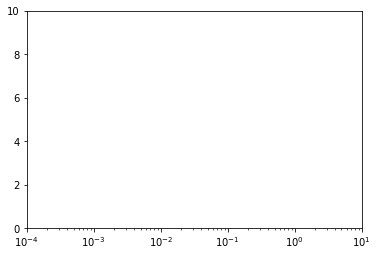

In [ ]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])

In [ ]:
def create_model():
    model = create_uncompiled_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2,momentum=0.9),
                  metrics=["mae"])

    return model

In [ ]:
model = create_model()
history = model.fit(train_set, epochs=50)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 64, 64)            256       
                                                                 
 bidirectional_2 (Bidirectio  (None, 64, 128)          66048     
 nal)                                                            
                                                                 
 lstm_7 (LSTM)               (None, 64, 32)            20608     
                                                                 
 lstm_8 (LSTM)               (None, 20)                4240      
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                      

In [ ]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

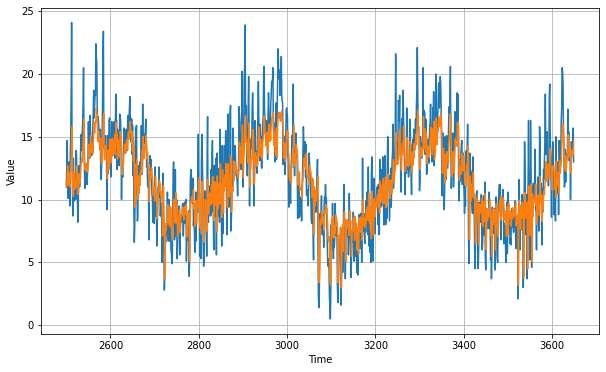

In [ ]:
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
mse, mae = compute_metrics(series_valid, rnn_forecast)
print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 5.46, mae: 1.81 for forecast


In [ ]:
model.save('saved_model/my_model')
! tar -czvf saved_model.tar.gz saved_model/

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


saved_model/
saved_model/my_model/
saved_model/my_model/keras_metadata.pb
saved_model/my_model/variables/
saved_model/my_model/variables/variables.data-00000-of-00001
saved_model/my_model/variables/variables.index
saved_model/my_model/saved_model.pb
saved_model/my_model/assets/
